# Twitter @WeRateDogs Analysis by Gaganpreet Singh

![alt text](dog-rates-social.jpg "Title")

In [8]:
#importing neccessary libraries
import tweepy
import pandas as pd
import requests
import json
import numpy as np
import re
import time
import matplotlib.pyplot as plt
%matplotlib inline

## Gathering the date

In [9]:
# Import the Twitter archive CSV file into a DataFrame
twitter_Arc_df = pd.read_csv('twitter-archive-enhanced.csv')

In [10]:
#Printing sample 5 rows from twitter archive data
twitter_Arc_df.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1096,736365877722001409,NaN,NaN,2016-05-28 01:18:00 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Rory. He's extremely impatient. 11/10 ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/736365877...,11,10,Rory,None,None,pupper,None
382,827228250799742977,NaN,NaN,2017-02-02 18:52:38 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Phil. He's an important...,6.946697e+17,4.196984e+09,2016-02-02 23:52:22 +0000,https://twitter.com/dog_rates/status/694669722...,12,10,Phil,None,None,None,None
1970,673295268553605120,NaN,NaN,2015-12-06 00:17:55 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Eve. She's a raging alcoholic 8/10 (would...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/673295268...,8,10,Eve,None,None,pupper,None
23,887473957103951883,NaN,NaN,2017-07-19 00:47:34 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Canela. She attempted some fancy porch...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/887473957...,13,10,Canela,None,None,None,None
839,767191397493538821,NaN,NaN,2016-08-21 02:47:37 +0000,"<a href=""http://twitter.com/download/iphone"" r...",I don't know any of the backstory behind this ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/767191397...,13,10,None,doggo,None,None,None


In [11]:
# Download tweet image predictions TSV using the Requests library and write it to image_predictions.tsv
url = ' https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)
with open('image_predictions.tsv', mode='wb') as file:
    file.write(response.content)
# Import the tweet image predictions TSV file into a DataFrame
twitter_img_df = pd.read_csv('image_predictions.tsv', sep = '\t')

In [12]:
twitter_img_df.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [13]:
# Declare Twitter API keys and access tokens
consumer_key = 'your consumer key'
consumer_secret = ''
access_token = ''
access_secret = ''

In [14]:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

In [15]:
api = tweepy.API(auth_handler=auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

In [ ]:
tweet_ids = twitter_Arc_df.tweet_id.values
len(tweet_ids)

# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = time.time()
# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = time.time()
print((end - start)/(1000*60))

In [18]:
# Reading tweet's JSON data line by line and later convert to a DataFrame with the help of list of dictionaries
record = []
with open('tweet-json.txt', 'r') as json_file:
    for line in json_file:
        data = json.loads(line)
        
        record.append({'tweet_id': data['id'],
                       'retweet_count': data['retweet_count'],
                       'favorite_count': data['favorite_count'],
                       'display_text_range': data['display_text_range']
                      })

# Create a DataFrame with tweet ID, retweet count, favorite count and display_text_range
twitter_api_df = pd.DataFrame(record, columns = ['tweet_id', 'retweet_count', 'favorite_count', 'display_text_range'])

In [19]:
twitter_api_df.head()

,tweet_id,retweet_count,favorite_count,display_text_range
0,892420643555336193,8853,39467,"[0, 85]"
1,892177421306343426,6514,33819,"[0, 138]"
2,891815181378084864,4328,25461,"[0, 121]"
3,891689557279858688,8964,42908,"[0, 79]"
4,891327558926688256,9774,41048,"[0, 138]"




## Assessing the data

In [20]:
twitter_Arc_df.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
262,842765311967449089,NaN,NaN,2017-03-17 15:51:22 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Indie. She's not a fan of baths but she's...,NaN,NaN,NaN,"https://www.gofundme.com/get-indie-home/,https...",12,10,Indie,None,None,None,None
1974,673148804208660480,NaN,NaN,2015-12-05 14:35:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Fletcher. He's had a ruff night. No mo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/673148804...,8,10,Fletcher,None,None,pupper,None
1846,675822767435051008,NaN,NaN,2015-12-12 23:41:18 +0000,"<a href=""http://twitter.com/download/iphone"" r...",🎶 HELLO FROM THE OTHER SIIIIIIIIDE 🎶 10/10s ht...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/675822767...,10,10,None,None,None,None,None
1242,711998809858043904,NaN,NaN,2016-03-21 19:31:59 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @twitter: @dog_rates Awesome Tweet! 12/10. ...,7.119983e+17,783214.0,2016-03-21 19:29:52 +0000,https://twitter.com/twitter/status/71199827977...,12,10,None,None,None,None,None
1706,680805554198020098,NaN,NaN,2015-12-26 17:41:07 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...",This guy's dog broke. So sad. 9/10 would still...,NaN,NaN,NaN,https://vine.co/v/iAP0Ugzi2PO,9,10,None,None,None,None,None


`twitter_Arc_df` (Twitter archive) columns:

- `tweet_id`: the unique identifier for each tweet
- `in_reply_to_status_id`: if the represented Tweet is a reply, this field will contain the integer representation of the original Tweet’s ID
- `in_reply_to_user_id': if the represented Tweet is a reply, this field will contain the integer representation of the original Tweet’s author ID
- `timestamp`: time when this Tweet was created
- `source`: utility used to post the Tweet, as an HTML-formatted string. e.g. Twitter for Android, Twitter for iPhone, Twitter Web Client
- `text`: actual UTF-8 text of the status update
- `retweeted_status_id`: if the represented Tweet is a retweet, this field will contain the integer representation of the original Tweet’s ID
- `retweeted_status_user_id`: if the represented Tweet is a retweet, this field will contain the integer representation of the original Tweet’s author ID
- `retweeted_status_timestamp`: time of retweet
- `expanded_urls`: tweet URL
- `rating_numerator`: numerator of the rating of a dog. Note: ratings almost always greater than 10
- `rating_denominator`: denominator of the rating of a dog. Note: ratings almost always have a denominator of 10
- `name`: name of the dog
- `doggo`: one of the 4 dog "stage"
- `floofer`: one of the 4 dog "stage"
- `pupper`: one of the 4 dog "stage"
- `puppo`: one of the 4 dog "stage"

In [21]:
twitter_Arc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [22]:
# Check if there are any records in arc_df which are retweets
len(twitter_Arc_df[twitter_Arc_df['retweeted_status_id'].isnull() == False])

181

In [23]:
#checking the occurrences of values in rating_denominator column
twitter_Arc_df.rating_denominator.value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [24]:
#checking the occurrences of values in rating_numerator column

twitter_Arc_df.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [25]:
#unique names in 'name' column
twitter_Arc_df.name.unique()

array(['Phineas', 'Tilly', 'Archie', 'Darla', 'Franklin', 'None', 'Jax',
       'Zoey', 'Cassie', 'Koda', 'Bruno', 'Ted', 'Stuart', 'Oliver',
       'Jim', 'Zeke', 'Ralphus', 'Canela', 'Gerald', 'Jeffrey', 'such',
       'Maya', 'Mingus', 'Derek', 'Roscoe', 'Waffles', 'Jimbo', 'Maisey',
       'Lilly', 'Earl', 'Lola', 'Kevin', 'Yogi', 'Noah', 'Bella',
       'Grizzwald', 'Rusty', 'Gus', 'Stanley', 'Alfy', 'Koko', 'Rey',
       'Gary', 'a', 'Elliot', 'Louis', 'Jesse', 'Romeo', 'Bailey',
       'Duddles', 'Jack', 'Emmy', 'Steven', 'Beau', 'Snoopy', 'Shadow',
       'Terrance', 'Aja', 'Penny', 'Dante', 'Nelly', 'Ginger', 'Benedict',
       'Venti', 'Goose', 'Nugget', 'Cash', 'Coco', 'Jed', 'Sebastian',
       'Walter', 'Sierra', 'Monkey', 'Harry', 'Kody', 'Lassie', 'Rover',
       'Napolean', 'Dawn', 'Boomer', 'Cody', 'Rumble', 'Clifford',
       'quite', 'Dewey', 'Scout', 'Gizmo', 'Cooper', 'Harold', 'Shikha',
       'Jamesy', 'Lili', 'Sammy', 'Meatball', 'Paisley', 'Albus',
       'Nept

In [26]:
# Number of records whose both doggo and floofer columns are not None
len(twitter_Arc_df[(twitter_Arc_df.doggo != 'None') & (twitter_Arc_df.floofer != 'None')])


1

In [27]:
# Number of records whose both doggo and pupper columns are not None
len(twitter_Arc_df[(twitter_Arc_df.doggo != 'None') & (twitter_Arc_df.pupper != 'None')])


12

In [28]:
# Number of records whose both doggo and puppo columns are not None
len(twitter_Arc_df[(twitter_Arc_df.doggo != 'None') & (twitter_Arc_df.puppo != 'None')])


1

In [29]:
# Number of records whose both floofer and pupper columns are not None
len(twitter_Arc_df[(twitter_Arc_df.floofer != 'None') & (twitter_Arc_df.pupper != 'None')])


0

In [30]:
# Number of records whose both floofer and puppo columns are not None

len(twitter_Arc_df[(twitter_Arc_df.floofer != 'None') & (twitter_Arc_df.puppo != 'None')])


0

In [31]:
# Number of records whose both puppo and pupper columns are not None

len(twitter_Arc_df[(twitter_Arc_df.puppo != 'None') & (twitter_Arc_df.pupper != 'None')])


0

In [32]:
## Number of records whose floofer, pupper and puppo columns are not None

len(twitter_Arc_df[(twitter_Arc_df.floofer != 'None') & (twitter_Arc_df.pupper != 'None') & (twitter_Arc_df.puppo != 'None')])


0

In [33]:
# Number of records whose floofer, pupper, puppo, doggo  columns are not None
len(twitter_Arc_df[(twitter_Arc_df.floofer != 'None') & (twitter_Arc_df.pupper != 'None') & (twitter_Arc_df.puppo != 'None') & (twitter_Arc_df.doggo != 'None')])


0

In [35]:
twitter_img_df.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
400,673688752737402881,https://pbs.twimg.com/media/CVlsVs3WIAAja6m.jpg,1,soft-coated_wheaten_terrier,0.340806,True,Sealyham_terrier,0.234898,True,kuvasz,0.203495,True
871,697943111201378304,https://pbs.twimg.com/media/Ca-XjfiUsAAUa8f.jpg,1,Great_Dane,0.126924,True,Greater_Swiss_Mountain_dog,0.110037,True,German_short-haired_pointer,0.090816,True
1583,796865951799083009,https://pbs.twimg.com/media/Cw8JWZ2UsAAJOZ6.jpg,1,Cardigan,0.839129,True,Boston_bull,0.080699,True,Pembroke,0.034505,True
1663,812372279581671427,https://pbs.twimg.com/media/C0YgO3DW8AAz98O.jpg,2,golden_retriever,0.784873,True,cocker_spaniel,0.087788,True,Labrador_retriever,0.083275,True
147,668631377374486528,https://pbs.twimg.com/media/CUd0sSvWsAA85wO.jpg,1,miniature_schnauzer,0.904549,True,Australian_terrier,0.022529,True,silky_terrier,0.015243,True


`twitter_image_df` (tweet image predictions) columns:

- `tweet_id`: the unique identifier for each tweet
- `jpg_url`: dog's image URL
- `img_num`: the image number that corresponded to the most confident prediction (numbered 1 to 4 since tweets can have up to four images)
- `p1`: algorithm's #1 prediction for the image in the tweet
- `p1_conf`: how confident the algorithm is in its #1 prediction
- `p1_dog`: whether or not the #1 prediction is a breed of dog
- `p2`: algorithm's #2 prediction for the image in the tweet
- `p2_conf`: how confident the algorithm is in its #2 prediction
- `p2_dog`: whether or not the #2 prediction is a breed of dog
- `p3`: algorithm's #3 prediction for the image in the tweet
- `p3_conf`: how confident the algorithm is in its #3 prediction
- `p3_dog`: whether or not the #3 prediction is a breed of dog

In [37]:
twitter_img_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [38]:
twitter_api_df.sample(5)

,tweet_id,retweet_count,favorite_count,display_text_range
309,835309094223372289,24013,0,"[0, 88]"
2208,668620235289837568,45,211,"[0, 144]"
387,826598365270007810,2709,11117,"[0, 75]"
1924,674053186244734976,1441,3576,"[0, 136]"
2318,666437273139982337,52,131,"[0, 138]"


`twitter_Api_df` (tweet status) columns:

- `id`: the unique identifier for each tweet
- `retweet_count`: number of times this Tweet has been retweeted
- `favorite_count`: indicates approximately how many times this Tweet has been liked by Twitter users
- `display_text_range`: an array of two unicode code point indices, identifying the inclusive start and exclusive end of the displayable content of the tweet

In [39]:
twitter_api_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 4 columns):
tweet_id              2354 non-null int64
retweet_count         2354 non-null int64
favorite_count        2354 non-null int64
display_text_range    2354 non-null object
dtypes: int64(3), object(1)
memory usage: 73.6+ KB


## Quality issues

`twitter_arc_df`(Twitter archive) table

- also contains retweets other than original tweets
- many tweet_id(s) of `twitter_arc_df` table are missing in `twitter_img_df` (image predictions) table
- erroneous datatypes in `in_reply_to_status_id`, `in_reply_to_user_id` and `timestamp` columns
- unnecessary html tags in `source` column in place of utility name 
e.g. <a href=""http://twitter.com/download/iphone""rel=""nofollow"">Twitter for iPhone</a>
- `text` column contains unneccessary text
- `rating_denominator` column has values other than 10
- incorrect dog names starting with lowercase characters (e.g. a, an, actually, by)
- some records have more than one dog stage

## Tidyness issues

- `twitter_arc_df` - Original tweets will have empty `retweeted_status_id`, `retweeted_status_user_id` and `retweeted_status_timestamp` columns, which can be dropped
- Reshape `twitter_arc_df`- `doggo`, `floofer`, `pupper` and `puppo` columns should be merged into one column named `stage`
- New column called `breed` column should be added in `twitter_arc_df` table from `twitter_img_df`
- `retweet_count` and `favorite_count` columns from `twitter_api_df` table should be joined with `twitter_arc_df` table

## Cleaning the data

In [40]:
# Take a copy of arc_df on which the cleaning tasks will be performed
twitter_Arc_df_clean = twitter_Arc_df.copy()
twitter_img_df_clean = twitter_img_df.copy()
twitter_api_df_clean = twitter_api_df.copy()

### Quality

- **`twitter_Arc_df` contains retweets**

#### *Define*

 Remove the records which are **retweets** (i.e. `retweeted_status_id` column is null)

#### Code

In [41]:
twitter_Arc_df_clean = twitter_Arc_df_clean[twitter_Arc_df_clean.retweeted_status_id.isnull()]

#### Test

In [42]:
sum(twitter_Arc_df_clean.retweeted_status_id.isnull() == False)

0

**any tweet_id(s) of `twitter_arc_df` table are missing in `twitter_img_df` (image predictions) table**

#### *Define*

Keep only those records in `twitter_Arc_df` table whose `tweet_id` exists in `twitter_image_df` table

#### Code

In [44]:
twitter_Arc_df_clean = twitter_Arc_df_clean[twitter_Arc_df_clean.tweet_id.isin(twitter_img_df.tweet_id)]

#### Test

In [45]:
sum(~twitter_Arc_df_clean.tweet_id.isin(twitter_img_df.tweet_id))

0


**Erroneous datatypes in `in_reply_to_status_id`, `in_reply_to_user_id` and `timestamp` columns**


#### *Define*

Convert `in_reply_to_status_id` and `in_reply_to_user_id` to data type integer. Convert `timestamp` to datetime data type

#### Code

In [46]:
twitter_Arc_df_clean.in_reply_to_status_id = twitter_Arc_df_clean.in_reply_to_status_id.fillna(0)
twitter_Arc_df_clean.in_reply_to_user_id = twitter_Arc_df_clean.in_reply_to_user_id.fillna(0)

twitter_Arc_df_clean.in_reply_to_status_id = twitter_Arc_df_clean.in_reply_to_status_id.astype(np.int64)
twitter_Arc_df_clean.in_reply_to_user_id = twitter_Arc_df_clean.in_reply_to_user_id.astype(np.int64)

twitter_Arc_df_clean.timestamp = pd.to_datetime(twitter_Arc_df_clean.timestamp)

#### Test

In [47]:
twitter_Arc_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      1994 non-null int64
in_reply_to_status_id         1994 non-null int64
in_reply_to_user_id           1994 non-null int64
timestamp                     1994 non-null datetime64[ns]
source                        1994 non-null object
text                          1994 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 1994 non-null object
rating_numerator              1994 non-null int64
rating_denominator            1994 non-null int64
name                          1994 non-null object
doggo                         1994 non-null object
floofer                       1994 non-null object
pupper                        1994 non-null object
puppo                         1994 non-null object
dtypes: datetime64[ns](1), flo

**unnecessary html tags in `source` column in place of utility name 
e.g. <a href=""http://twitter.com/download/iphone""rel=""nofollow"">Twitter for iPhone</a>**

#### *Define*

Strip all html anchor tags (i.e. <a..></a>) in source column and retain just the text in between the tags. Convert the datatype from string to categorical.

#### Code

In [48]:
twitter_Arc_df_clean['source'] = twitter_Arc_df_clean['source'].str.extract(r'.+>(.+)<.+')

In [49]:
twitter_Arc_df_clean.source = twitter_Arc_df_clean.source.astype('category')

#### Test

In [50]:
twitter_Arc_df_clean['source'].unique()

[Twitter for iPhone, Twitter Web Client, TweetDeck]
Categories (3, object): [Twitter for iPhone, Twitter Web Client, TweetDeck]

In [51]:
twitter_Arc_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      1994 non-null int64
in_reply_to_status_id         1994 non-null int64
in_reply_to_user_id           1994 non-null int64
timestamp                     1994 non-null datetime64[ns]
source                        1994 non-null category
text                          1994 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 1994 non-null object
rating_numerator              1994 non-null int64
rating_denominator            1994 non-null int64
name                          1994 non-null object
doggo                         1994 non-null object
floofer                       1994 non-null object
pupper                        1994 non-null object
puppo                         1994 non-null object
dtypes: category(1), datetim

 **`text` column contains unneccessary text**

#### *Define*

extract relevant text from `text` column

#### Code

In [52]:
twitter_Arc_df_clean.iloc[210].text


'Say hello to Maddie and Gunner. They are considerably pupset about bath time. Both 12/10 but Gunner needs your help\n\nhttps://t.co/JesYTzb1Jo https://t.co/5cncH08G1o'

In [53]:
twitter_Arc_df_clean.iloc[20].text
twitter_Arc_df_clean['text'] = twitter_Arc_df_clean['text'].str.extract(r'(.+ \d+/\d+).+')


#### Test

In [54]:
twitter_Arc_df_clean.iloc[210].text

'Say hello to Maddie and Gunner. They are considerably pupset about bath time. Both 12/10'

**`rating_denominator` column has values other than 10**

#### *Define*

For records whose `rating_denominator` is greater than 10 and divisible by 10, use the quotient of denominator/10 as the divisor to divide the `rating_numerator`. If the numerator turns out to be divisible (i.e. remainder=0), assign this quotient as the `rating_numerator`.**Eg: 48/40 will get converted to 12/10**

For the remaining records, check if the text column contains any fraction whose denominator is 10. If it does, update the `rating_numerator` with the numerator value of this fraction.

#### Code

In [55]:
# iterate through all those records whose rating_denominator is not 10
for i, row in twitter_Arc_df_clean[twitter_Arc_df_clean.rating_denominator != 10].iterrows():
    
    # if rating_denominator is greater than 10 and divisible by 10
    if row.rating_denominator > 10 and row.rating_denominator%10 == 0:
        # assign divisor as the quotient
        divisor = row.rating_denominator/10
        n = row.rating_numerator
        
        # if rating_numerator is greater than 10 and divisible by the divisor
        if n%divisor == 0:
            # reassign rating_denominator as 10
            twitter_Arc_df_clean.set_value(i, 'rating_denominator', 10)
            # reassign rating_numerator as the quotient of rating_numerator by divisor
            twitter_Arc_df_clean.set_value(i, 'rating_numerator', int(n/divisor))
    
    # for all those records whose rating_denominator is either less than 10 or not divisible by 10
    else:
        # extract all fractions(ratings) from text using tokens function
        pattern = re.compile('.+ (\d+)/(\d+).+')
        # iterate through all the fractions
        fractions = pattern.findall(str(row.text))
        if(len(fractions)>0): 
            # if denominator of any such fraction is equal to 10
            if (fractions[0][1] == '10'):
                # reassign rating_denominator as 10
                archive_clean.set_value(i, 'rating_denominator', 10)
                # reassign rating_numerator as the numerator value of this fraction
                archive_clean.set_value(i, 'rating_numerator', int(fractions[0][0]))
            

C:\Users\singh\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  del sys.path[0]
C:\Users\singh\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  from ipykernel import kernelapp as app


#### Test

In [56]:
twitter_Arc_df_clean.rating_denominator.value_counts()

10    1990
11       2
7        1
2        1
Name: rating_denominator, dtype: int64

 **Incorrect dog names starting with lowercase characters (e.g. a, an, actually, by)**

#### Define

Replace all lowercase values of name column with **None**

#### Code

In [57]:
twitter_Arc_df_clean.name.unique()

array(['Phineas', 'Tilly', 'Archie', 'Darla', 'Franklin', 'None', 'Jax',
       'Zoey', 'Cassie', 'Koda', 'Bruno', 'Ted', 'Stuart', 'Oliver',
       'Jim', 'Zeke', 'Ralphus', 'Gerald', 'Jeffrey', 'such', 'Canela',
       'Maya', 'Mingus', 'Derek', 'Roscoe', 'Waffles', 'Jimbo', 'Maisey',
       'Earl', 'Lola', 'Kevin', 'Yogi', 'Noah', 'Bella', 'Grizzwald',
       'Rusty', 'Gus', 'Stanley', 'Alfy', 'Koko', 'Rey', 'Gary', 'a',
       'Elliot', 'Louis', 'Jesse', 'Romeo', 'Bailey', 'Duddles', 'Jack',
       'Steven', 'Beau', 'Snoopy', 'Shadow', 'Emmy', 'Aja', 'Penny',
       'Dante', 'Nelly', 'Ginger', 'Benedict', 'Venti', 'Goose', 'Nugget',
       'Cash', 'Jed', 'Sebastian', 'Sierra', 'Monkey', 'Harry', 'Kody',
       'Lassie', 'Rover', 'Napolean', 'Boomer', 'Cody', 'Rumble',
       'Clifford', 'Dewey', 'Scout', 'Gizmo', 'Walter', 'Cooper',
       'Harold', 'Shikha', 'Lili', 'Jamesy', 'Coco', 'Sammy', 'Meatball',
       'Paisley', 'Albus', 'Neptune', 'Belle', 'Quinn', 'Zooey', 'Dave',
    

In [58]:
twitter_Arc_df_clean.name.nunique()

936

In [59]:
twitter_Arc_df_clean.name = twitter_Arc_df_clean.name.str.replace('^[a-z]+', 'None')

#### Test

In [60]:
twitter_Arc_df_clean.name.unique()

array(['Phineas', 'Tilly', 'Archie', 'Darla', 'Franklin', 'None', 'Jax',
       'Zoey', 'Cassie', 'Koda', 'Bruno', 'Ted', 'Stuart', 'Oliver',
       'Jim', 'Zeke', 'Ralphus', 'Gerald', 'Jeffrey', 'Canela', 'Maya',
       'Mingus', 'Derek', 'Roscoe', 'Waffles', 'Jimbo', 'Maisey', 'Earl',
       'Lola', 'Kevin', 'Yogi', 'Noah', 'Bella', 'Grizzwald', 'Rusty',
       'Gus', 'Stanley', 'Alfy', 'Koko', 'Rey', 'Gary', 'Elliot', 'Louis',
       'Jesse', 'Romeo', 'Bailey', 'Duddles', 'Jack', 'Steven', 'Beau',
       'Snoopy', 'Shadow', 'Emmy', 'Aja', 'Penny', 'Dante', 'Nelly',
       'Ginger', 'Benedict', 'Venti', 'Goose', 'Nugget', 'Cash', 'Jed',
       'Sebastian', 'Sierra', 'Monkey', 'Harry', 'Kody', 'Lassie',
       'Rover', 'Napolean', 'Boomer', 'Cody', 'Rumble', 'Clifford',
       'Dewey', 'Scout', 'Gizmo', 'Walter', 'Cooper', 'Harold', 'Shikha',
       'Lili', 'Jamesy', 'Coco', 'Sammy', 'Meatball', 'Paisley', 'Albus',
       'Neptune', 'Belle', 'Quinn', 'Zooey', 'Dave', 'Jersey', 'Hobbes

In [61]:
twitter_Arc_df_clean.name.nunique()

914

s**ome records have more than one dog stage**

#### *Define*

There is **one** record that has both doggo and floofer and another record that has both doggo and puppo. For these 2 records, take a look at the text manually to decide one dog stage for each of them.

There are **12** records which have both doggo and pupper. As per the dogtionary, doggo and pupper are sometimes used interchangeably. Therefore, set pupper column as None for these records.

#### Code

In [62]:
for i, row in twitter_Arc_df_clean[(twitter_Arc_df_clean.doggo != 'None') & 
                                   (twitter_Arc_df_clean.floofer != 'None')].iterrows():
    tweet_id_df = row.tweet_id
    print(row.tweet_id, row.text)

854010172552949760 At first I thought this was a shy doggo, but it's actually a Rare Canadian Floofer Owl. Amateurs would confuse the two. 11/10


In [63]:
for i, row in twitter_Arc_df_clean[(twitter_Arc_df_clean.doggo != 'None') & 
                                    (twitter_Arc_df_clean.puppo != 'None')].iterrows():
    tweet_id_dp = row.tweet_id
    print(row.tweet_id, row.text)

855851453814013952 Here's a puppo participating in the #ScienceMarch. Cleverly disguising her own doggo agenda. 13/10


In [64]:
# based on the above texts, doggo should be set as None for both the records
twitter_Arc_df_clean['doggo'][twitter_Arc_df_clean.tweet_id.isin([tweet_id_df, tweet_id_dp])] = 'None'

C:\Users\singh\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [65]:
# set pupper column as None for records which have both doggo and pupper
twitter_Arc_df_clean['pupper'][(twitter_Arc_df_clean.doggo != 'None') & (twitter_Arc_df_clean.pupper != 'None')] = 'None'

C:\Users\singh\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


#### Test

In [66]:
len(twitter_Arc_df_clean[((twitter_Arc_df_clean.doggo != 'None') & (twitter_Arc_df_clean.pupper != 'None'))
                  | ((twitter_Arc_df_clean.doggo != 'None') & (twitter_Arc_df_clean.floofer != 'None')) 
                  | ((twitter_Arc_df_clean.doggo != 'None') & (twitter_Arc_df_clean.puppo != 'None'))])

0

## Tidyness

`twitter_arc_df` - Original tweets will have empty `retweeted_status_id`, `retweeted_status_user_id` and `retweeted_status_timestamp` columns, which can be dropped

#### Define

- Drop `retweeted_status_id`, `retweeted_status_user_id` and `retweeted_status_timestamp` columns from `twitter_Arc_df` table

#### Code

In [67]:
twitter_Arc_df_clean.drop(['retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp'], axis=1, inplace=True)

#### Test

In [68]:
twitter_Arc_df_clean.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo'],
      dtype='object')

**Reshape `twitter_arc_df`- `doggo`, `floofer`, `pupper` and `puppo` columns should be merged into one column named `stage`.
**

#### Define

Columns `doggo`, `floofer`, `pupper` and `puppo` columns in `twitter_Arc_df` table should be merged into one column named `stage` using pythons **Melt** function. Convert the datatype from string to **Categorical**

#### Code

In [69]:
#Reshaping the twitter_Arc_df and storing the updated one into new dataframe
melted_twitter_Arc_df = pd.melt(twitter_Arc_df_clean, id_vars = ["tweet_id", "in_reply_to_status_id",
                                                                 "in_reply_to_user_id", "timestamp",
                                                                "source","text","expanded_urls","rating_numerator",
                                                                "rating_denominator","name"],value_name = "stage") 

In [70]:
melted_twitter_Arc_df['stage'].value_counts()

None       7670
pupper      203
doggo        72
puppo        23
floofer       8
Name: stage, dtype: int64

In [71]:
#Removing the 'variable' column created by melt function
melted_twitter_Arc_df.drop(['variable'], axis = 1, inplace = True)

In [72]:
#Removing the unneccessary duplicated
melted_twitter_Arc_df.drop_duplicates(inplace=True)

In [73]:
#Removing some more trash columns created by melt function
melted_copy = melted_twitter_Arc_df.copy()
for i, row in melted_copy.iterrows():
    if (len(melted_twitter_Arc_df[melted_twitter_Arc_df['tweet_id'] == row.tweet_id]) == 2):
        if (row.stage == "None"):
            melted_twitter_Arc_df.drop(i, inplace = True)
            
#updating the original dataframe
twitter_Arc_df_clean = melted_twitter_Arc_df.copy()

In [74]:
# convert the datatype from string to categorical
twitter_Arc_df_clean.stage = twitter_Arc_df_clean.stage.astype('category')

#### Test

In [75]:
twitter_Arc_df_clean['stage'].value_counts()

None       1688
pupper      203
doggo        72
puppo        23
floofer       8
Name: stage, dtype: int64

In [76]:
twitter_Arc_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 6795
Data columns (total 11 columns):
tweet_id                 1994 non-null int64
in_reply_to_status_id    1994 non-null int64
in_reply_to_user_id      1994 non-null int64
timestamp                1994 non-null datetime64[ns]
source                   1994 non-null category
text                     1945 non-null object
expanded_urls            1994 non-null object
rating_numerator         1994 non-null int64
rating_denominator       1994 non-null int64
name                     1994 non-null object
stage                    1994 non-null category
dtypes: category(2), datetime64[ns](1), int64(5), object(3)
memory usage: 160.0+ KB


**New column called `breed` should be added in `twitter_arc_df` table from `twitter_img_df`**

#### Define

Create breed in `twitter_arc_df` table. For each tweet_id, use the `twitter_img_df` table to check if `p1_conf` is greater than 0.95 (i.e. 95% confidence interval) and `p1_dog` is True. If it is, set the value of `p1` column in `breed` column.

#### Code

In [80]:
twitter_Arc_df_clean['breed'] = 'None'
for i, row in twitter_Arc_df_clean.iterrows():
    
    img_prediction = twitter_img_df[twitter_img_df.tweet_id == row.tweet_id]
    p1_conf = img_prediction.p1_conf.iloc[0]
    p1_dog = img_prediction.p1_dog.iloc[0]
    #  check if p1_conf is greater than 0.95 (i.e. 95% confidence interval) and p1_dog is True
    if p1_conf >= 0.95 and p1_dog:
        twitter_Arc_df_clean.set_value(i, 'breed', img_prediction.p1.iloc[0])

C:\Users\singh\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  if __name__ == '__main__':


In [81]:
twitter_Arc_df_clean.breed.unique()

array(['None', 'Samoyed', 'French_bulldog', 'Blenheim_spaniel',
       'Pembroke', 'vizsla', 'basset', 'pug', 'Labrador_retriever',
       'Shetland_sheepdog', 'komondor', 'Chihuahua', 'golden_retriever',
       'Bernese_mountain_dog', 'Brittany_spaniel', 'Great_Pyrenees',
       'Norwegian_elkhound', 'Pekinese', 'Old_English_sheepdog',
       'Pomeranian', 'bull_mastiff', 'malamute', 'chow', 'Siberian_husky',
       'Saint_Bernard', 'keeshond', 'toy_poodle', 'beagle',
       'German_shepherd', 'Weimaraner', 'cocker_spaniel', 'Maltese_dog',
       'Rottweiler', 'Tibetan_mastiff', 'German_short-haired_pointer',
       'Great_Dane', 'Boston_bull', 'schipperke', 'English_springer',
       'dalmatian', 'Cardigan', 'collie', 'Shih-Tzu', 'briard', 'boxer',
       'miniature_pinscher'], dtype=object)

**`retweet_count` and `favorite_count` columns from `status_df` table should be joined with `twitter_arc_df` table**

#### Define

Fetch the `retweet_count` and `favorite_count` columns of `twitter_api_df` table and assign those values to `twitter_arc_df` table

#### Code

In [82]:
twitter_Arc_df_clean['retweet_count'] = 0
twitter_Arc_df_clean['favorite_count'] = 0

for i, row in twitter_Arc_df_clean.iterrows():
    # fetch the retweet_count and favorite_count columns of status_df table and assign those values
    twitter_Arc_df_clean.set_value(i, 'retweet_count', twitter_api_df[twitter_api_df.tweet_id == row.tweet_id].retweet_count.iloc[0])
    twitter_Arc_df_clean.set_value(i, 'favorite_count', twitter_api_df[twitter_api_df.tweet_id == row.tweet_id].favorite_count.iloc[0])    

C:\Users\singh\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\singh\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  import sys


#### Test

In [83]:
twitter_Arc_df_clean[['tweet_id', 'retweet_count', 'favorite_count']].sample(5)

,tweet_id,retweet_count,favorite_count
800,740373189193256964,9220,20648
1237,688789766343622656,759,2434
1249,687664829264453632,576,2121
1166,693622659251335168,422,1691
6060,874012996292530176,11007,35501


In [84]:
twitter_Arc_df_clean.sample()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,stage,breed,retweet_count,favorite_count
784,743210557239623680,0,0,2016-06-15 22:36:19,Twitter for iPhone,"Meet Kayla, an underground poker legend. Playe...",https://twitter.com/dog_rates/status/743210557...,10,10,Kayla,None,None,1560,4215


## Storing the data

In [85]:
twitter_Arc_df_clean.to_csv('twitter_archive_master.csv', encoding='utf-8', index=False)
twitter_img_df_clean.to_csv('twitter_image_prediction_master.csv', encoding = 'utf-8', index = False)

## Analyzing the data

In [86]:
twitter_Arc_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 6795
Data columns (total 14 columns):
tweet_id                 1994 non-null int64
in_reply_to_status_id    1994 non-null int64
in_reply_to_user_id      1994 non-null int64
timestamp                1994 non-null datetime64[ns]
source                   1994 non-null category
text                     1945 non-null object
expanded_urls            1994 non-null object
rating_numerator         1994 non-null int64
rating_denominator       1994 non-null int64
name                     1994 non-null object
stage                    1994 non-null category
breed                    1994 non-null object
retweet_count            1994 non-null int64
favorite_count           1994 non-null int64
dtypes: category(2), datetime64[ns](1), int64(7), object(4)
memory usage: 286.7+ KB


**Analyzing number of tweets posted by WeRateDogs' over time**

In [87]:
twitter_Arc_df_clean['timestamp'].apply(lambda x: x.strftime('%Y-%m')).value_counts()

2015-12    367
2015-11    296
2016-01    169
2016-03    120
2016-02    111
2016-07     88
2016-06     81
2017-01     66
2016-10     65
2017-02     64
2016-09     63
2016-08     59
2016-05     57
2016-04     54
2016-12     54
2016-11     53
2017-07     49
2017-03     48
2017-06     44
2017-05     43
2017-04     41
2017-08      2
Name: timestamp, dtype: int64

**Most used Twitter source**

In [88]:
twitter_Arc_df_clean['source'].value_counts()

Twitter for iPhone    1955
Twitter Web Client      28
TweetDeck               11
Name: source, dtype: int64

**Analysis of rating of dogs**

In [89]:
twitter_Arc_df_clean['rating_numerator'].value_counts().sort_index()

0         2
1         5
2        10
3        19
4        15
5        33
6        32
7        52
8        95
9       152
10      421
11      402
12      454
13      261
14       35
24        1
26        1
27        1
75        1
420       1
1776      1
Name: rating_numerator, dtype: int64

In [90]:
sum(twitter_Arc_df_clean['rating_numerator'] > 10)/twitter_Arc_df_clean['rating_numerator'].count()*100

58.07422266800402

<font color=blue>`Insight`: Out of a total of **1994** dogs rated by WeRateDogs,almost **60%** of dogs were rated **above 10**.</font>

**Analysis of dog breed (as identified by image prediction)**

In [91]:
twitter_Arc_df_clean['breed'].value_counts()

None                           1808
pug                              20
Pembroke                         19
Samoyed                          19
golden_retriever                 16
Pomeranian                       13
Chihuahua                         9
Labrador_retriever                9
French_bulldog                    8
chow                              7
Bernese_mountain_dog              4
German_shepherd                   4
Shetland_sheepdog                 4
Blenheim_spaniel                  3
Old_English_sheepdog              3
beagle                            3
Pekinese                          3
basset                            2
Shih-Tzu                          2
cocker_spaniel                    2
vizsla                            2
dalmatian                         2
komondor                          2
malamute                          2
keeshond                          2
Boston_bull                       2
Saint_Bernard                     2
English_springer            

**Analysis of retweet and favorite counts**

In [92]:
print('Mean Retweet Count', round(twitter_Arc_df_clean.retweet_count.mean()))
print('Mean Favorite Count', round(twitter_Arc_df_clean.favorite_count.mean()))

Mean Retweet Count 2767
Mean Favorite Count 8896


**When the dog is rated greater than 10**

In [93]:
print('Mean Retweet Count', 
                  round(twitter_Arc_df_clean[twitter_Arc_df_clean.rating_numerator > 10].retweet_count.mean()))
print('Mean Favorite Count', 
                  round(twitter_Arc_df_clean[twitter_Arc_df_clean.rating_numerator > 10].favorite_count.mean()))

Mean Retweet Count 3846
Mean Favorite Count 12797


**When the dog has a name**

In [94]:
print('Mean Retweet Count', 
                  round(twitter_Arc_df_clean[twitter_Arc_df_clean.name != 'None'].retweet_count.mean()))
print('Mean Favorite Count', 
                  round(twitter_Arc_df_clean[twitter_Arc_df_clean.name != 'None'].favorite_count.mean()))

Mean Retweet Count 2752
Mean Favorite Count 9408


**Based on Dog stage**

In [95]:
print('Doggo')
print('Mean Retweet Count', round(twitter_Arc_df_clean.retweet_count[twitter_Arc_df_clean.stage == 'doggo'].mean()))
print('Mean Favorite Count', 
                  round(twitter_Arc_df_clean.favorite_count[twitter_Arc_df_clean.stage == 'doggo'].mean()))

print('Floofer')
print('Mean Retweet Count', 
                  round(twitter_Arc_df_clean.retweet_count[twitter_Arc_df_clean.stage == 'floofer'].mean()))
print('Mean Favorite Count', 
                  round(twitter_Arc_df_clean.favorite_count[twitter_Arc_df_clean.stage == 'floofer'].mean()))

print('Pupper')
print('Mean Retweet Count', 
                  round(twitter_Arc_df_clean.retweet_count[twitter_Arc_df_clean.stage == 'pupper'].mean()))
print('Mean Favorite Count', 
                  round(twitter_Arc_df_clean.favorite_count[twitter_Arc_df_clean.stage == 'pupper'].mean()))

print('Puppo')
print('Mean Retweet Count', 
                  round(twitter_Arc_df_clean.retweet_count[twitter_Arc_df_clean.stage == 'puppo'].mean()))
print('Mean Favorite Count', 
                  round(twitter_Arc_df_clean.favorite_count[twitter_Arc_df_clean.stage == 'puppo'].mean()))

Doggo
Mean Retweet Count 6745
Mean Favorite Count 18503
Floofer
Mean Retweet Count 4777
Mean Favorite Count 13701
Pupper
Mean Retweet Count 2364
Mean Favorite Count 7198
Puppo
Mean Retweet Count 7027
Mean Favorite Count 22724


## Visualizing the data

In [96]:
#setting figure size parameters
plt.rcParams["figure.figsize"] = [15, 12]

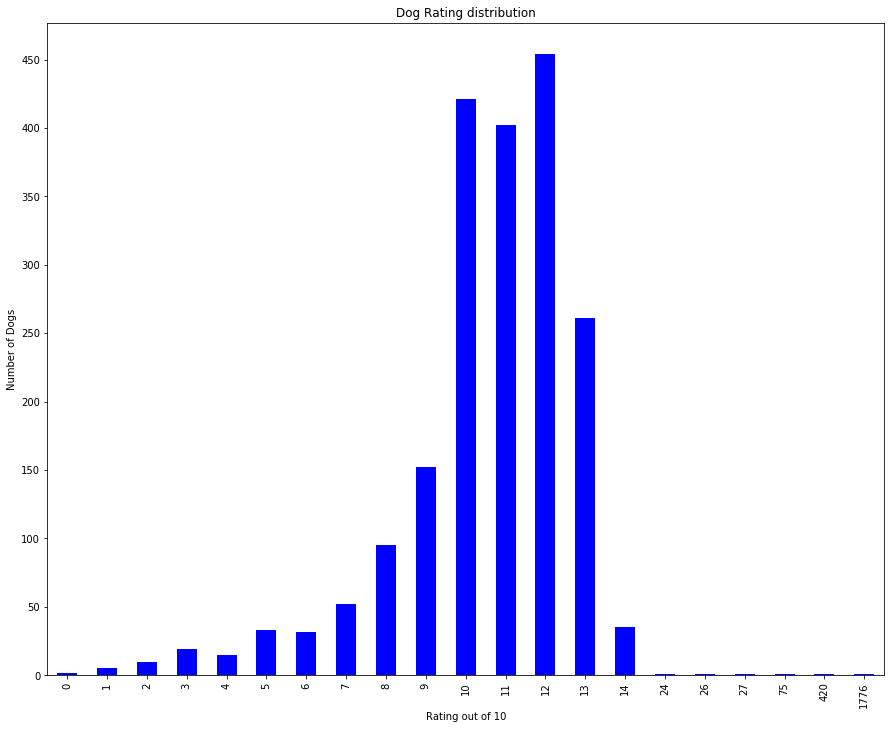

In [97]:
#plotting Dog ating distribution
rating_count = twitter_Arc_df_clean.rating_numerator.value_counts().sort_index()
rating_dist = rating_count.plot('bar', title = 'Dog Rating distribution',color='#0000ff')
rating_dist.set_xlabel("Rating out of 10")
rating_dist.set_ylabel("Number of Dogs")
rating_dist.set_yticks([0, 50, 100, 150, 200, 250, 300, 350, 400, 450])
plt.savefig('rating_dist')

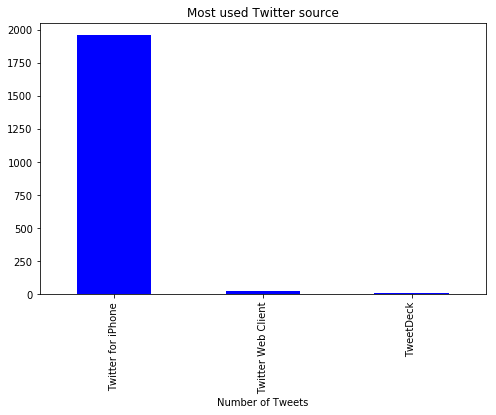

In [98]:
#Plotting the source used for tweeting
twitter_Arc_df_clean['source'].value_counts().plot('bar',figsize=(8,5),color='#0000ff', title='Most used Twitter source').set_xlabel("Number of Tweets")
plt.savefig('twitter_source')

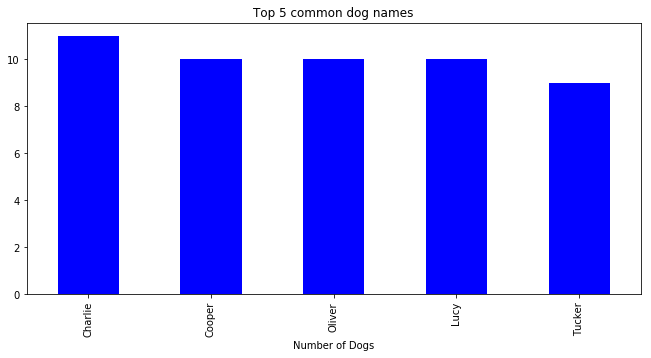

In [99]:
#plotting the top 5 dog name distribution
twitter_Arc_df_clean.name.value_counts()[1:6].plot('bar', figsize=(11,5), color='#0000ff',
                                                   title='Top 5 common dog names').set_xlabel("Number of Dogs")
plt.savefig('dog_names')

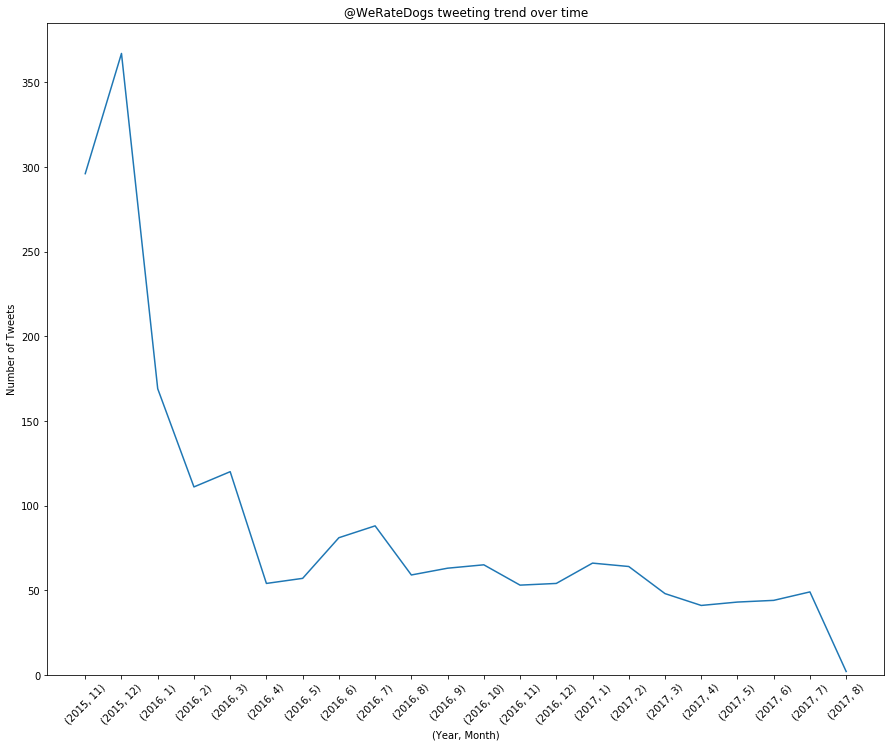

In [100]:
#plotting tweeting trend over time

year_month = twitter_Arc_df_clean.tweet_id.groupby([twitter_Arc_df_clean["timestamp"].dt.year,
                                           twitter_Arc_df_clean["timestamp"].dt.month]).count()
tweet_trend = year_month.plot('line', title = '@WeRateDogs tweeting trend over time')
tweet_trend.set_xlabel("(Year, Month)")
tweet_trend.set_ylabel("Number of Tweets")
tweet_trend.set_ylim(0, )
plt.xticks(list(range(len(year_month.index))),labels=year_month.index)
tweet_trend.set_xticklabels(year_month.index , rotation = 45)
plt.savefig('tweet_trend')

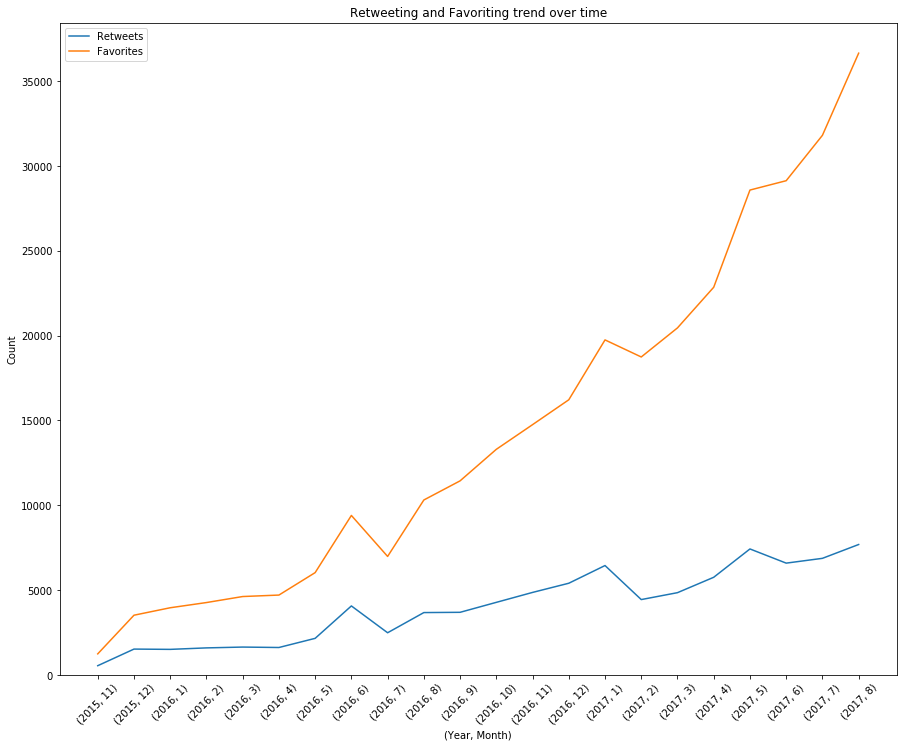

In [101]:
#plotting Retweeting and Favourite tweet trend over time

plt.subplots(1, sharex=True)
retweet_dist = twitter_Arc_df_clean.retweet_count.groupby([twitter_Arc_df_clean["timestamp"].dt.year, 
                                            twitter_Arc_df_clean["timestamp"].dt.month]).mean()
retweet_trend = retweet_dist.plot('line')
favourite_trend = twitter_Arc_df_clean.favorite_count.groupby([twitter_Arc_df_clean["timestamp"].dt.year,
                                             twitter_Arc_df_clean["timestamp"].dt.month]).mean().plot('line').set_ylim(0, )
plt.title('Retweeting and Favoriting trend over time')
plt.ylabel('Count')
plt.xlabel('(Year, Month)')
plt.legend(('Retweets', 'Favorites'))
plt.xticks(list(range(len(retweet_dist.index))),labels=retweet_dist.index)
retweet_trend.set_xticklabels(retweet_dist.index,rotation = 45)
plt.savefig('ret_fav')